In [10]:
!pip -q install yfinance

import os, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import yfinance as yf

os.makedirs("figures", exist_ok=True)


In [35]:
!rm -rf stocknet-dataset
!git clone --depth 1 https://github.com/yumoxu/stocknet-dataset.git

tweet_dir = "stocknet-dataset/tweet/preprocessed"
price_pre_dir = "stocknet-dataset/price/preprocessed"
price_raw_dir = "stocknet-dataset/price/raw"


print("tweet_dir exists:", os.path.exists(tweet_dir))
print("price_pre_dir exists:", os.path.exists(price_pre_dir))

# tickers from tweet folders
tweet_tickers = sorted([d for d in os.listdir(tweet_dir) if os.path.isdir(os.path.join(tweet_dir, d))])

# tickers from price .txt files
price_tickers = sorted([f.replace(".txt","") for f in os.listdir(price_pre_dir) if f.endswith(".txt")])

valid_tickers = sorted(list(set(tweet_tickers).intersection(price_tickers)))

print("tweet tickers:", len(tweet_tickers))
print("price tickers:", len(price_tickers))
print("valid tickers:", len(valid_tickers), "sample:", valid_tickers[:10])


Cloning into 'stocknet-dataset'...
remote: Enumerating objects: 53751, done.
remote: Counting objects: 100% (53751/53751), done.
remote: Compressing objects: 100% (25112/25112), done.
remote: Total 53751 (delta 28639), reused 53749 (delta 28639), pack-reused 0 (from 0)
Receiving objects: 100% (53751/53751), 66.94 MiB | 16.78 MiB/s, done.
Resolving deltas: 100% (28639/28639), done.
Updating files: 100% (55141/55141), done.
tweet_dir exists: True
price_pre_dir exists: True
tweet tickers: 87
price tickers: 88
valid tickers: 87 sample: ['AAPL', 'ABB', 'ABBV', 'AEP', 'AGFS', 'AMGN', 'AMZN', 'BA', 'BABA', 'BAC']


## 2) Build dataset

In [40]:
import pandas as pd
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed

BASE = "https://raw.githubusercontent.com/yumoxu/stocknet-dataset/master/tweet/raw/{ticker}/{date}"

def fetch_day(ticker: str, date: str, timeout=30) -> pd.DataFrame:
    url = BASE.format(ticker=ticker, date=date)
    r = requests.get(url, timeout=timeout)
    if r.status_code != 200 or not r.text.strip():
        return pd.DataFrame()

    # Parseing JSON Lines from the response body
    df = pd.read_json(pd.io.common.StringIO(r.text), lines=True)

    # Adding metadata
    df["ticker"] = ticker
    df["date"] = date
    return df

def load_week(tickers, dates, max_workers=8) -> pd.DataFrame:
    frames = []
    tasks = []

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        for t in tickers:
            for d in dates:
                tasks.append(ex.submit(fetch_day, t, d))

        for fut in as_completed(tasks):
            df = fut.result()
            if not df.empty:
                frames.append(df)

    if not frames:
        return pd.DataFrame()

    out = pd.concat(frames, ignore_index=True)

    return out

tickers = ["AAPL", "AMZN", "GOOG", "ABB", "MU", "META", "SNAP", "NVDA", "AVGO", "TSLA", "PCSA", "MGRT", "JMG", "PFE", "JNJ", "ORCL", "CAT", "COIN"]
dates = pd.date_range("2015-01-01", periods=30, freq="D").strftime("%Y-%m-%d").tolist()

week_df = load_week(tickers, dates, max_workers=8)
print(week_df.shape)
print(week_df.columns)


(175, 27)
Index(['created_at', 'id', 'id_str', 'text', 'source', 'truncated',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'retweet_count', 'favorite_count', 'entities',
       'favorited', 'retweeted', 'possibly_sensitive', 'filter_level', 'lang',
       'retweeted_status', 'ticker', 'date'],
      dtype='object')


In [46]:
from __future__ import annotations

import json
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, Iterable, List, Optional, Union


PathLike = Union[str, Path]


import os
import json
import pandas as pd

def read_stocknet_docs(
    ticker,
    base_dir="stocknet-dataset",
    max_days=400,
    max_tweets=30,
):

    # Reads tweet/raw/<TICKER>/<YYYY-MM-DD> files.

    ticker_dir = os.path.join(base_dir, "tweet", "raw", ticker)
    if not os.path.isdir(ticker_dir):
        return [], []

    day_files = sorted(os.listdir(ticker_dir))
    if not day_files:
        return [], []

    dates = []
    docs = []

    # keep only last max_days
    day_files = day_files[-max_days:]

    for day in day_files:
        fp = os.path.join(ticker_dir, day)
        if not os.path.isfile(fp):
            continue

        texts = []

        try:
            with open(fp, "r", encoding="utf-8", errors="ignore") as f:
                for line in f:
                    if len(texts) >= max_tweets:
                        break

                    line = line.strip()
                    if not line:
                        continue

                    obj = json.loads(line)

                    # extract tweet text safely
                    if "full_text" in obj:
                        txt = obj["full_text"]
                    elif "extended_tweet" in obj and "full_text" in obj["extended_tweet"]:
                        txt = obj["extended_tweet"]["full_text"]
                    else:
                        txt = obj.get("text", "")

                    if txt:
                        texts.append(txt)

        except Exception:
            continue

        if texts:
            dates.append(day)
            docs.append("\n".join(texts))

    return dates, docs

def read_stocknet_tweets(
    repo_root: PathLike,
    symbol: str,
    date: str,
    *,
    raw: bool = True,
    keep_bad_lines: bool = False,
) -> List[Dict[str, Any]]:

    # Read StockNet tweet data for one symbol + date.

    repo_root = Path(repo_root)
    base = repo_root / "tweet" / ("raw" if raw else "preprocessed") / symbol
    p = base / date
    if not p.exists():
        raise FileNotFoundError(f"Not found: {p}")

    tweets: List[Dict[str, Any]] = []
    with p.open("r", encoding="utf-8", errors="replace") as f:
        for i, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            try:
                tweets.append(json.loads(line))
            except json.JSONDecodeError as e:
                if keep_bad_lines:
                    continue
                raise ValueError(f"Bad JSON on line {i} in {p}: {e}") from e
    return tweets


def extract_tweet_text(tweet_obj: Dict[str, Any]) -> str:
    # Some exports include 'extended_tweet' or 'full_text'
    if "full_text" in tweet_obj and isinstance(tweet_obj["full_text"], str):
        return tweet_obj["full_text"]
    if "extended_tweet" in tweet_obj and isinstance(tweet_obj["extended_tweet"], dict):
        ft = tweet_obj["extended_tweet"].get("full_text")
        if isinstance(ft, str):
            return ft
    return str(tweet_obj.get("text", ""))


In [47]:
import os
import pandas as pd

def norm_date(x) -> str:
    # Return YYYY-MM-DD string from str/datetime/Timestamp
    return str(pd.to_datetime(x, errors="coerce").date())

def read_movement_from_raw(stock, price_raw_dir):
    # Reads price/raw/<STOCK>.csv and returns:
    fp = os.path.join(price_raw_dir, f"{stock}.csv")
    if not os.path.exists(fp):
        return {}

    # load price CSV
    p = pd.read_csv(fp)

    cols = {c.lower().strip(): c for c in p.columns}
    if "date" not in cols or "close" not in cols:
        return {}

    date_col = cols["date"]
    close_col = cols["close"]

    # parse + clean
    p[date_col] = pd.to_datetime(p[date_col], errors="coerce")
    p[close_col] = pd.to_numeric(p[close_col], errors="coerce")

    p = p.dropna(subset=[date_col, close_col])
    p = p.sort_values(date_col).reset_index(drop=True)

    # compute next-day movement
    p["next_close"] = p[close_col].shift(-1)
    p = p.dropna(subset=["next_close"])

    p["label"] = (p["next_close"] > p[close_col]).astype(int)

    movement = {
        d.strftime("%Y-%m-%d"): int(lab)
        for d, lab in zip(p[date_col], p["label"])
    }

    return movement



rows = []
subset = valid_tickers[:30]

# quick sanity counters
no_price = 0
no_docs = 0
no_overlap = 0

for s in subset:
    mv = read_movement_from_raw(s, price_raw_dir)
    if not mv:
        no_price += 1
        continue

    mv_norm = {norm_date(k): v for k, v in mv.items()}

    dates, docs = read_stocknet_docs(s, max_days=400, max_tweets=30)
    if not dates or not docs:
        no_docs += 1
        continue

    n = min(len(dates), len(docs))
    dates_norm = [norm_date(d) for d in dates[:n]]
    docs = docs[:n]

    matched = 0
    for d, doc in zip(dates_norm, docs):
        label = mv_norm.get(d)
        if label is None:
            continue

        rows.append(
            {"ticker": s, "date": d, "text": doc, "label": label}
        )
        matched += 1

    if matched == 0:
        no_overlap += 1

df = pd.DataFrame(rows)
print("df shape:", df.shape)
print("df columns:", df.columns.tolist())
print("no_price:", no_price, "no_docs:", no_docs, "no_overlap:", no_overlap)
df.head()


df shape: (5950, 4)
df columns: ['ticker', 'date', 'text', 'label']
no_price: 0 no_docs: 0 no_overlap: 0


,ticker,date,text,label
0,AAPL,2015-02-13,Logging into Option Millionaires LIVE chat NOW...,1
1,AAPL,2015-02-17,"Absolutely, just as $TSLA and $GOOG have shown...",1
2,AAPL,2015-02-18,"THE BINARY OPTIONS COMPETITION WIN $100,000 ht...",0
3,AAPL,2015-02-19,RT @AppleReporter: Apple Up +16.6% YTD\nUp 7 C...,1
4,AAPL,2015-02-20,"iPhones, electric cars, and personal robots? C...",1


In [48]:
X = df['text'].tolist(); y = df['label'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
vec = TfidfVectorizer(max_features=30000, ngram_range=(1,2))
Xtr = vec.fit_transform(X_train)
Xte = vec.transform(X_test)
clf = LogisticRegression(max_iter=2000)
clf.fit(Xtr, y_train)
pred = clf.predict(Xte)
acc = accuracy_score(y_test, pred)
mf1 = f1_score(y_test, pred, average='macro')
print('Movement Accuracy:', acc)
print('Movement Macro-F1:', mf1)
print('Confusion Matrix:\n', confusion_matrix(y_test, pred))


Movement Accuracy: 0.5302521008403361
Movement Macro-F1: 0.5300101528150569
Confusion Matrix:
 [[302 290]
 [269 329]]


Regime split via VIX

In [50]:
import numpy as np
import pandas as pd
import yfinance as yf

# VIX series
vix = yf.download("^VIX", start="2014-01-01", end="2016-01-10",
                  progress=False, auto_adjust=False)

if isinstance(vix.columns, pd.MultiIndex):
    vix_close = vix["Close"].iloc[:, 0]
else:
    vix_close = vix["Close"]

vix = (vix_close
       .dropna()
       .rename("vix")
       .reset_index()
       .rename(columns={"Date": "date"}))

vix["date"] = pd.to_datetime(vix["date"], errors="coerce").dt.tz_localize(None)

df2 = df.copy()
df2["date"] = pd.to_datetime(df2["date"], errors="coerce").dt.tz_localize(None)

df2 = df2.dropna(subset=["date"])
vix = vix.dropna(subset=["date"])

df2 = df2.sort_values("date")
vix = vix.sort_values("date")

df2 = pd.merge_asof(df2, vix, on="date", direction="backward")


df2 = df2.dropna(subset=["vix"])

th = df2["vix"].median()
df2["regime"] = np.where(df2["vix"] >= th, "high_vol", "low_vol")
print(df2["regime"].value_counts())


regime
high_vol    2985
low_vol     2965
Name: count, dtype: int64


In [51]:
def eval_slice(df_slice, name):
    X = df_slice['text'].tolist(); y = df_slice['label'].tolist()
    if len(y) < 100 or len(set(y)) < 2:
        return None
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    vec = TfidfVectorizer(max_features=30000, ngram_range=(1,2))
    Xtr = vec.fit_transform(X_train); Xte = vec.transform(X_test)
    clf = LogisticRegression(max_iter=2000)
    clf.fit(Xtr, y_train)
    pred = clf.predict(Xte)
    return {'slice': name, 'n': len(df_slice), 'accuracy': float(accuracy_score(y_test, pred)), 'macro_f1': float(f1_score(y_test, pred, average='macro'))}

res_reg = []
for reg in ['low_vol','high_vol']:
    r = eval_slice(df2[df2['regime']==reg], f'regime={reg}')
    if r: res_reg.append(r)
pd.DataFrame(res_reg)

,slice,n,accuracy,macro_f1
0,regime=low_vol,2965,0.524452,0.514950
1,regime=high_vol,2985,0.534338,0.512988


## 5) Sector slice (best-effort)

In [52]:
def get_sector(ticker):
    try:
        return yf.Ticker(ticker).info.get('sector', None)
    except Exception:
        return None

sector_map = {t: get_sector(t) for t in sorted(df2['ticker'].unique().tolist())}
df2['sector'] = df2['ticker'].map(sector_map)
df2['sector'].value_counts().head(10)

,count
sector,
Communication Services,754
Healthcare,728
Industrials,629
Financial Services,623
Energy,611
Technology,572
Consumer Cyclical,568
Utilities,549
Basic Materials,228


In [53]:
res_sec = []
for sector, g in df2.groupby('sector'):
    if pd.isna(sector):
        continue
    r = eval_slice(g, f'sector={sector}')
    if r: res_sec.append(r)
df_sector = pd.DataFrame(res_sec).sort_values('macro_f1', ascending=False)
df_sector.head(10)

,slice,n,accuracy,macro_f1
5,sector=Financial Services,623,0.600000,0.594156
3,sector=Consumer Defensive,122,0.560000,0.557166
9,sector=Utilities,549,0.545455,0.526515
7,sector=Industrials,629,0.515873,0.513390
1,sector=Communication Services,754,0.569536,0.511619
2,sector=Consumer Cyclical,568,0.491228,0.490601
4,sector=Energy,611,0.536585,0.475421
6,sector=Healthcare,728,0.534247,0.460435
8,sector=Technology,572,0.530435,0.454114
0,sector=Basic Materials,228,0.456522,0.370553


## 6) Save figures + CSV tables

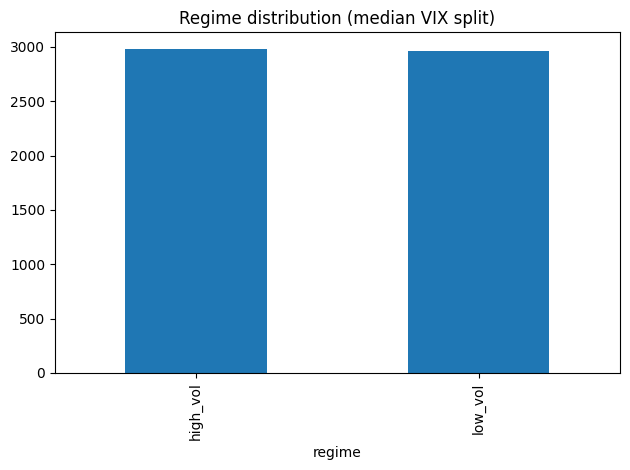

Saved: movement_results_overall.csv, movement_results_regime.csv, movement_results_sector.csv


In [54]:
df2['regime'].value_counts().plot(kind='bar')
plt.title('Regime distribution (median VIX split)')
plt.tight_layout()
plt.savefig('figures/regime_distribution.png', dpi=200)
plt.show()

pd.DataFrame([{'slice':'overall','n':len(df),'accuracy':acc,'macro_f1':mf1}]).to_csv('movement_results_overall.csv', index=False)
pd.DataFrame(res_reg).to_csv('movement_results_regime.csv', index=False)
df_sector.to_csv('movement_results_sector.csv', index=False)
print('Saved: movement_results_overall.csv, movement_results_regime.csv, movement_results_sector.csv')